# DeepLabCut Ingestion/Inference

# DeepLabCut manual:
https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/standardDeepLabCut_UserGuide.md

`Dev notes:` Currently, the path structure assumes you have one DLC project directory for all models, as specified within `adamacs.pipeline.get_dlc_root_data_dir`. The parallel function `get_dlc_processed_data_dir` can specify the output directory. 

## TODO

1. Have the DLC model as selector in the Pingest GUI (model.Model() = model_name)
2. Add a checkbox to process DLC data
3. model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True}, task_mode = 'trigger') - have additional options in table?
4. model.RecordingInfo.populate()
model.RecordingInfo()
5. model.PoseEstimation.populate()
6. defer population to tmux or cron jobs?


## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [2]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

[2023-08-01 19:44:37,695][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-08-01 19:44:37,744][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

In [3]:
dj.config["custom"].get("dlc_root_data_dir")


['/datajoint-data/models/tobiasr/DB_DLC_tracking',
 '/datajoint-data/models/tobiasr/NK_DLC_tracking',
 '/']

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates items.

In [4]:
from adamacs.pipeline import subject, train,  scan, event, trial, behavior, session, model, equipment, imaging

## Ingesting videos and training parameters

### Automated

Refer the `user_data` folder in the `adamacs` directory contains CSVs for inserting values into DeepLabCut tables.

1. `config_params.csv` is used for training parameter sets in `train.TrainingParamSet`. The following items are required, but others will also be passed to DLC's `train_network` function when called 
2. `train_videosets.csv` and `model_videos.csv` pass values to `train.VideoSet` and `model.VideoRecording` respectively.
3. `adamacs.ingest.dlc.ingest_dlc_items` will load each of these CSVs

For more information, see [this notebook](https://github.com/CBroz1/workflow-deeplabcut/blob/main/notebooks/04-Automate_Optional.ipynb)

In [5]:
    # from adamacs.ingest.dlc import ingest_dlc_items
    # ingest_dlc_items()

In [ ]:
# model.VideoRecording().delete()
# model.Model.delete()

In [ ]:
train.schema.list_tables()

In [ ]:
model.schema.list_tables()

### Manual

The same training parameters as above can be manually inserted as follows.

In [10]:
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir
import pathlib
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'from_top_tracking-DJ-2022-02-23/config.yaml')
config_path

PosixPath('/datajoint-data/models/tobiasr/DB_DLC_tracking/from_top_tracking-DJ-2022-02-23/config.yaml')

In [4]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FJBPNSP,scan9FJBPNSP,0,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4


In [ ]:
scansi = "scan9FJ842C3"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 0})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 1})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FHELAYA"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*copy*.mp4"))[0])
# moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4-copy.mp4"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 2})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
model.VideoRecording() * model.VideoRecording.File() * equipment.Device()

## Model Training

The `TrainingTask` table queues up training. To launch training from a different machine, one needs to edit DLC's config files to reflect updated paths. For training, this includes `dlc-models/*/*/train/pose_cfg.yaml`

`CB DEV NOTE:` I'm missing the following videos used to originally train the model:
- top_video2022-02-17T15_56_10.mp4
- top_video2022-02-21T12_18_09.mp4

#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

We recommend storing all paths as relative to the root in your config.

In [ ]:
# train.VideoSet.delete()

In [ ]:
train.VideoSet.insert1({'video_set_id': 0}, skip_duplicates=True)
project_folder = 'from_top_tracking-DJ-2022-02-23/'
training_files = ['labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png',
                  'videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 0,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

In [ ]:
train.VideoSet.insert1({'video_set_id': 1}, skip_duplicates=True)
project_folder = 'Head_orientation-NK-2023-07-17/'
training_files = ['labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png',
                  'videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

In [ ]:
train.VideoSet.delete()

The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [ ]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [ ]:
train.TrainingParamSet()

In [ ]:
import yaml

paramset_idx = 0; paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
paramset_idx = 1; paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
train.TrainingParamSet()

In [ ]:
# train.TrainingTask.delete()

In [ ]:
key={'video_set_id': 0, 
     'paramset_idx':0,
     'training_id':0, # uniquely defines training task
     'project_path':'from_top_tracking-DJ-2022-02-23/' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
key={'video_set_id': 1, 
     'paramset_idx':1,
     'training_id':1, # uniquely defines training task
     'project_path':'Head_orientation-NK-2023-07-17' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
(train.TrainingParamSet & "paramset_idx=1").fetch("params")

In [ ]:
# (train.TrainingTask() & ("video_set_id = 1")).delete()
train.TrainingTask()

In [ ]:
train.ModelTraining.populate()

To start training from a previous instance, one would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70) and
adjust the `maxiters` paramset (if present) to a higher threshold (e.g., 10 for 5 more itterations).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

## Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [5]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
Head_orientation-NK,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, trained 5 iterations",1


In [6]:
model.BodyPart.heading

body_part            : varchar(32)                  # 
---
body_part_description="" : varchar(1000)                # 

This table is equipped with two helper functions. First, we can identify all the new body parts from a given config file.

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')
model.BodyPart.extract_new_body_parts(config_path)

Now, we can make a list of descriptions in the same order, and insert them into the table

In [ ]:
model.BodyPart()

In [ ]:
# Will be inserted with model insertion
# bp_desc=['Body Center', 'Head', 'Base of Tail']
# model.BodyPart.insert_from_config(config_path,bp_desc)

If we skip this step, body parts (without descriptions) will be added when we insert a model. We can [update](https://docs.datajoint.org/python/v0.13/manipulation/3-Cautious-Update.html) empty descriptions at any time.

## Declaring a Model

If training appears successful, the result can be inserted into the `Model` table for automatic evaluation.

In [ ]:
paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

In [ ]:
model.Model.insert_new_model(model_name='from_top_tracking-DJ',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=0)

In [ ]:
paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

In [7]:
config_path

NameError: name 'config_path' is not defined

In [ ]:
model.Model.insert_new_model(model_name='Head_orientation-NK',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=1)

In [8]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
Head_orientation-NK,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, trained 5 iterations",1


In [6]:
model.VideoRecording * model.VideoRecording.File() * session.SessionUser * subject.User() * session.Session() * scan.ScanInfo * scan.ScanInfo.Field()

session_id,recording_id,file_id,user_id,scan_id,field_idx,camera,"file_path filepath of video, relative to root data directory",name,shorthand TR: added name_FirstInitialSurname shorthand,initials Update after pyrat ingestion,email TR: for completeness' sake also email,"lab short lab name, pyrat labid",subject PyRat import uses this for earmark value,session_datetime,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,zoom scan zoom factor,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELAYA,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELMRY,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELX2S,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHEMBE2,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELMRY,0,7,scan9FHELAYA,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELMRY,0,7,scan9FHELMRY,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00

In [10]:
model.Model().fetch("config_template")

array([{'Task': 'Head_orientation', 'scorer': 'NK', 'date': 'Jul17', 'multianimalproject': False, 'identity': None, 'project_path': '/datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17', 'video_sets': {'/datajoint-data/models/tobiasr/DeepLabCutModels/NK_DLC_tracking/Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4': {'crop': '0, 1000, 0, 1000'}}, 'bodyparts': ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail'], 'start': 0, 'stop': 1, 'numframes2pick': 100, 'skeleton': [['bodypart1', 'bodypart2'], ['objectA', 'bodypart3']], 'skeleton_color': 'black', 'pcutoff': 0.6, 'dotsize': 12, 'alphavalue': 0.7, 'colormap': 'rainbow', 'TrainingFraction': [0.95], 'iteration': 0, 'default_net_type': 'resnet_50', 'default_augmenter': 'default', 'snapshotindex': 3, 'batch_size': 8, 'cropping': False, 'x1': 0, 'x2': 640, 'y1': 277, 'y2': 624, 'corner2move2': [50, 50], 'move2corner': True}],
      dtype=object)

In [ ]:
model.Model.BodyPart()

## Model Evaluation

Next, all inserted models can be evaluated with a similar `populate` method, which will
insert the relevant output from DLC's `evaluate_network` function.

In [12]:
model.ModelEvaluation.heading

# 
model_name           : varchar(64)                  # User-friendly model name
---
train_iterations     : int                          # Training iterations
train_error=null     : float                        # Train error (px)
test_error=null      : float                        # Test error (px)
p_cutoff=null        : float                        # p-cutoff used
train_error_p=null   : float                        # Train error with p-cutoff
test_error_p=null    : float                        # Test error with p-cutoff

In [13]:
model.ModelEvaluation.populate()

2023-08-01 12:51:09.726406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 12:51:09.877550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-08-01 12:51:09.877571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-01 12:51:09.910958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Running  DLC_resnet50_Head_orientationJul17shuffle1_90000  with # of training iterations: 90000
This net has already been evaluated!


If your project was initialized in a version of DeepLabCut other than the one you're currently using, model evaluation may report key errors. Specifically, your `config.yaml` may not specify `multianimalproject: false`.

In [14]:
model.ModelEvaluation()

model_name User-friendly model name,train_iterations Training iterations,train_error Train error (px),test_error Test error (px),p_cutoff p-cutoff used,train_error_p Train error with p-cutoff,test_error_p Test error with p-cutoff
Head_orientation-NK,100000,3.12,3.19,0.6,3.12,3.19


In [15]:
model.RecordingInfo.populate()
model.RecordingInfo() * model.VideoRecording.File()

session_id,recording_id,file_id,px_height height in pixels,px_width width in pixels,nframes number of frames,fps (Hz) frames per second,recording_datetime Datetime for the start of the recording,recording_duration video duration (s) from nframes / fps,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,1000,1000,36162,60,None,602.7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,1000,1000,36171,60,None,602.85,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,1000,1000,36189,60,None,603.15,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,1000,1000,36162,60,None,602.7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FJBPNSP,scan9FJBPNSP,0,1000,1000,36337,60,None,605.617,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4


## Pose Estimation

In [11]:
scansi = "scan9FHELMRY"
scan_key = (model.VideoRecording.File & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4'],
      dtype=object)

In [12]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FHS7Y22,scan9FHS7Y22,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_top_video_2023-04-28T12_42_12.mp4
sess9FHS7Y22,scan9FHS845A,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_top_video_2023-04-28T12_53_47.mp4
sess9FIG39RU,scan9FIG39RU,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG39RU_sess9FIG39RU/scan9FIG39RU_top_video_2023-06-07T15_01_05.mp4
sess9FIG39RU,scan9FIG3GCJ,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3GCJ_sess9FIG39RU/scan9FIG3GCJ_top_video_2023-06-07T15_13_23.mp4
sess9FIG39RU,scan9FIG3MU8,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3MU8_sess9FIG39RU/scan9FIG3MU8_top_video_2023-06-07T15_20_34.mp4
sess9FJBPNSP,scan9FJBPNSP,0,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4


For demonstration purposes, we'll make a shorter video that will process relatively quickly `ffmpeg`, a DLC dependency ([more info here](https://github.com/datajoint/workflow-deeplabcut/blob/main/notebooks/00-DataDownload_Optional.ipynb))

In [13]:
from adamacs.paths import get_dlc_root_data_dir
vid_path =  find_full_path(get_dlc_root_data_dir(), path[0][1::])
print(vid_path)
starttime = 0
duration = 10
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss {starttime} -t {duration} -i {vid_path} '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4


0

In [ ]:
model.VideoRecording.delete()

Next, we need to specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters accepted by the `analyze_videos` function as a dictionary. `task_mode` determines if pose estimation results should be loaded or triggered (i.e., load vs. trigger).

In [28]:
key = (model.VideoRecording & {'recording_id': 'scan9FJBPNSP'}).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})
key



{'session_id': 'sess9FJBPNSP',
 'recording_id': 'scan9FJBPNSP',
 'model_name': 'Head_orientation-NK',
 'task_mode': 'trigger'}

The `PoseEstimationTask` table queues items for pose estimation. Additional parameters are passed to DLC's `analyze_videos` function.

In [16]:
model.PoseEstimationTask()

session_id,recording_id,model_name User-friendly model name,task_mode load results or trigger computation,pose_estimation_output_dir output dir relative to the root dir,"pose_estimation_params analyze_videos params, if not default"
sess9FHELAYA,scan9FHELAYA,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHELMRY,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELMRY_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHELX2S,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELX2S_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHEMBE2,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/device_mini2p1_top_recording_scan9FHEMBE2_model_Head_orientation-NK,=BLOB=
sess9FJBPNSP,scan9FJBPNSP,Head_orientation-NK,load,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK,=BLOB=


In [ ]:
train.ModelTraining()

In [ ]:
# model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True})
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,100)}) # dynamic cropping

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo()

In [17]:
model.PoseEstimation.populate()

In [ ]:
model.PoseEstimationTask().delete()
model.PoseEstimation().delete()

# Data Evaluation

By default, DataJoint will store the results of pose estimation in a subdirectory
>  processed_dir / videos / device_<#>_recording_<#>_model_<name>

Pulling processed_dir from `get_dlc_processed_dir`, and device/recording information 
from the `VideoRecording` table. The model name is taken from the primary key of the
`Model` table, with spaced replaced by hyphens.
    
We can get this estimation directly as a pandas dataframe.

In [ ]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

In [19]:
scansi = "scan9FJBPNSP"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4'],
      dtype=object)

In [20]:
imaging.Curation()

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FH37WBZ,scan9FH37WBZ,0,1,2023-08-01 12:32:53,/datajoint-data/data/tobiasr/JJ_ROS-1487_2023-03-17_scan9FH37WBZ_sess9FH37WBZ,0,
sess9FHELAYA,scan9FHELAYA,0,1,2023-08-01 12:52:12,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA,0,
sess9FHELAYA,scan9FHELMRY,0,1,2023-08-01 12:53:27,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA,0,
sess9FHELAYA,scan9FHELX2S,0,1,2023-08-01 12:54:55,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA,0,
sess9FHELAYA,scan9FHEMBE2,0,1,2023-08-01 12:56:24,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA,0,
sess9FHS7Y22,scan9FHS7Y22,0,1,2023-08-01 13:05:53,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22,0,
sess9FHS7Y22,scan9FHS845A,0,1,2023-08-01 13:06:59,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22,0,
sess9FIG39RU,scan9FIG39RU,0,1,2023-08-01 13:07:36,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG39RU_sess9FIG39RU,0,
sess9FIG39RU,scan9FIG3GCJ,0,1,2023-08-01 13:08:18,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3GCJ_sess9FIG39RU,0,
sess9FIG39RU,scan9FIG3MU8,0,1,2023-08-01 13:09:30,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3MU8_sess9FIG39RU,0,


In [21]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

[array([array([ 83.70710155,  86.86541605,  88.54746652, ..., 621.64152241,
               622.07046366, 621.24676228])                                ],
       dtype=object),
 array([array([728.11305714, 727.17423463, 728.69017625, ..., 944.85496259,
               944.77177   , 945.56375027])                                ],
       dtype=object)]

In [22]:
#reduce dataframe to xy coordinates
df=model.PoseEstimation.get_trajectory(scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
df_xy

bodyparts body_middle             head_middle                left_ear   
coords              x           y           x           y           x   
0          130.920777  706.750298   83.707102  728.113057   93.652415  \
1          134.619499  708.959919   86.865416  727.174235   98.150693   
2          131.131657  708.102064   88.547467  728.690176   96.806626   
3          132.958229  706.780612   92.855093  729.107165  101.077982   
4          130.558305  705.947532   96.713384  728.817565  103.065166   
...               ...         ...         ...         ...         ...   
36332      583.683363  966.969059  621.038152  943.463164  605.183202   
36333      584.456383  967.607391  622.054756  944.686156  607.556064   
36334      584.071240  967.469453  621.641522  944.854963  605.102971   
36335      584.453458  967.560652  622.070464  944.771770  607.663898   
36336      582.343778  967.665559  621.246762  945.563750  605.728098   

bodyparts                    neck                    nose               
coords              y           x           y           x           y   
0          740.209740   92.927191  724.644492   70.806308  744.316727  \
1          742.799294   98.707413  724.829966   78.008384  747.205724   
2          743.125870   98.071034  726.361199   81.926775  747.487347   
3          743.172414  101.976781  727.446666   89.318563  749.426769   
4          741.363503  104.031522  726.259680   90.156514  751.911568   
...               ...         ...         ...         ...         ...   
36332      934.150157  614.184631  951.821500  637.215863  932.167042   
36333      934.376274  613.407482  954.735601  635.188989  933.271298   
36334      935.525781  612.760555  954.474961  637.943188  932.819397   
36335      934.415929  613.353115  954.753798  635.285389  933.329197   
36336      935.185004  611.420425  955.126198  633.764942  934.165777   

bodyparts   right_ear                    tail              
coords              x           y           x           y  
0           82.676140  710.518631  151.528423  690.387672  
1           90.060568  707.289467  154.212643  690.994244  
2           88.654797  711.327076  151.254512  691.320163  
3           93.992166  712.872608  152.708105  689.303003  
4           97.881099  712.241217  150.463195  689.882112  
...               ...         ...         ...         ...  
36332      630.546502  960.401065  555.099199  961.425680  
36333      628.537492  967.096449  554.915121  961.641817  
36334      631.261743  960.985356  555.042113  960.911247  
36335      628.508523  967.176376  555.153718  961.339915  
36336      624.205909  968.954758  554.184010  960.905695  

[36337 rows x 14 columns]

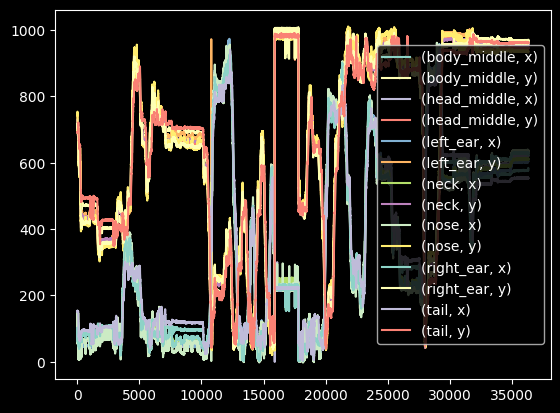

In [23]:
df_xy.plot().legend(loc='right')

In [24]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

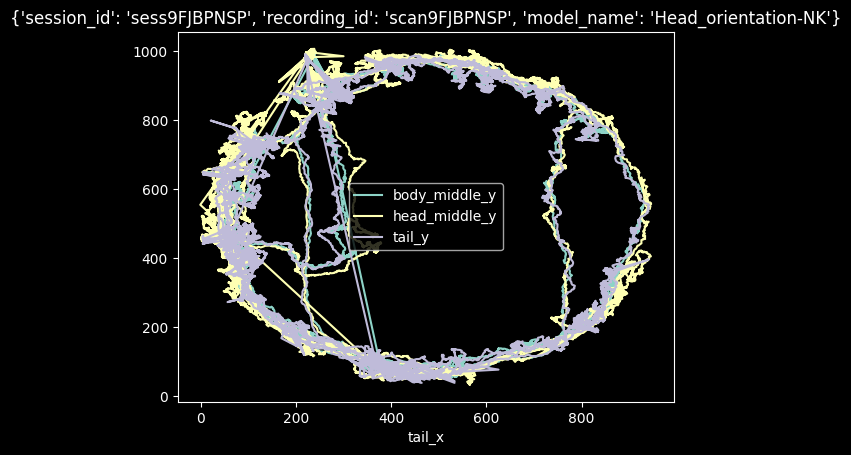

In [25]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
plt.title(scan_key)
plt.show()

In [30]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

PosixPath('/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK')

In [31]:
key

{'session_id': 'sess9FJBPNSP',
 'recording_id': 'scan9FJBPNSP',
 'model_name': 'Head_orientation-NK',
 'task_mode': 'trigger'}

In [32]:
from deeplabcut.utils.make_labeled_video import create_labeled_video

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

Starting to process video: /datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4
Loading /datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4 and data.


Duration of video [s]: 605.62, recorded with 60.0 fps!
Overall # of frames: 36337 with cropped frame dimensions: 1000 1000
Generating frames and creating video.


100%|██████████| 36337/36337 [04:15<00:00, 142.32it/s]


[True]

In [35]:
destfolder

PosixPath('/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK')

In [39]:
moviepath = str(list(pathlib.Path(destfolder).glob("*.mp4"))[0])
moviepath


'/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK/scan9FJBPNSP_top_video_2023-07-30T17_38_30DLC_resnet50_Head_orientationJul17shuffle1_90000_labeled.mp4'

In [ ]:
(model.VideoRecording.File & key).fetch1("file_path")

In [ ]:
list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))